Проект 2 - разведывательный анализ данных
Задача проекта - провести разведывательный анализ данных и отобрать параметры, с помощью которых можно было бы создать модель, которая предсказывала бы результаты госэкзамена по математике для каждого ученика школы, чтобы на ранней стадии выявлять студентов, находящихся в группе риска.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind

In [2]:
students = pd.read_csv('stud_math.csv')
students.sample(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
222,GP,F,16,U,GT3,T,2.0,3.0,services,teacher,...,-6.0,yes,yes,no,2.0,3.0,1.0,3.0,385.0,85.0
295,GP,M,17,U,GT3,T,3.0,3.0,health,other,...,-3.0,yes,yes,no,4.0,4.0,3.0,5.0,4.0,55.0
36,GP,M,15,U,NaN,T,4.0,3.0,teacher,services,...,-9.0,yes,yes,no,5.0,4.0,3.0,4.0,2.0,90.0
267,GP,F,18,R,GT3,T,4.0,4.0,teacher,other,...,-6.0,yes,yes,no,4.0,3.0,4.0,4.0,8.0,55.0
305,GP,F,18,U,GT3,T,2.0,4.0,services,at_home,...,-6.0,yes,yes,no,4.0,4.0,3.0,3.0,8.0,60.0


In [3]:
students.describe()

,age,Medu,Fedu,traveltime,studytime,failures,"studytime, granular",famrel,freetime,goout,health,absences,score
count,395.000000,392.000000,371.000000,367.000000,388.000000,373.000000,388.000000,368.000000,384.000000,387.000000,380.000000,383.000000,389.000000
mean,16.696203,2.750000,2.614555,1.438692,2.038660,0.337802,-6.115979,3.937500,3.231771,3.105943,3.531579,7.279373,52.262211
std,1.276043,1.098127,2.228732,0.694181,0.842078,0.743135,2.526235,0.927277,0.993940,1.115896,1.396019,23.465197,22.919022
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,-12.000000,-1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,-6.000000,4.000000,3.000000,2.000000,3.000000,0.000000,40.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,-6.000000,4.000000,3.000000,3.000000,4.000000,4.000000,55.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,-3.000000,5.000000,4.000000,4.000000,5.000000,8.000000,70.000000
max,22.000000,4.000000,40.000000,4.000000,4.000000,3.000000,-3.000000,5.000000,5.000000,5.000000,5.000000,385.000000,100.000000


# Предобработка

Так как да или нет являются бинарными признаками, то имеет смысл перевести их к значения 1 и 0, потому что, во-первых, согласно тому что нагуглила, такие значения будут более полезны для модели машинного обучения в будущем (напишите мне, если это не так, пожалуйста); а во-вторых, позволит находит корреляцию с другими числовыми значениями

In [4]:
def yes_no(row):
    """Change to binary classification"""
    if row == 'yes':
        return 1
    if row == 'no':
        return 0
    return row

In [5]:
students['schoolsup'] = students.schoolsup.apply(yes_no)
students['famsup'] = students.famsup.apply(yes_no)
students['paid'] = students.paid.apply(yes_no)
students['activities'] = students.activities.apply(yes_no)
students['nursery'] = students.nursery.apply(yes_no)
students['higher'] = students.higher.apply(yes_no)
students['internet'] = students.internet.apply(yes_no)
students['romantic'] = students.romantic.apply(yes_no)

Начнем с обработки столбцов с числовыми данными, найдем выбросы, пропущенные значения, и заполним их

In [6]:
# Age. Все значения заполнены
students['age'].isnull().sum()

0

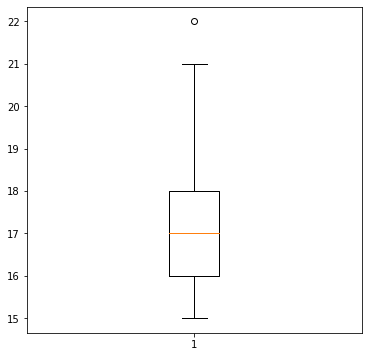

In [7]:
# Судя по графику, присутствуют выбросы, но нам необходимо предсказать оценки студентов в возрасте от 15 до 22 лет,
# так что это значение находится в нужных границах
fig = plt.figure(1, figsize=(6, 6))
ax = fig.add_subplot(111)

age = ax.boxplot(students.age)

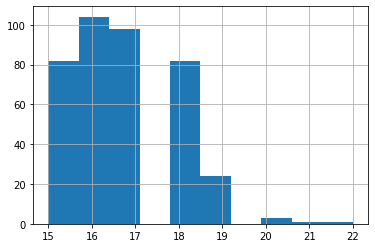

In [8]:
students.age.hist()

In [9]:
# Medu. 3 пустых значения.
students['Medu'].isnull().sum()

3

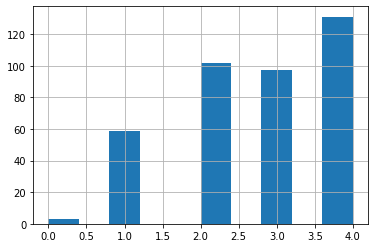

In [10]:
# Выбросов нет, все значения находятся в промежутке от 0 до 4 согласно заданным критериям
students.Medu.hist()

In [11]:
# я заполню пропущенные значения медианой, чтобы не изменять существующие статистические значения. Mean даст дробные 
# средние значения, которые невозможно будет отнести ни к одной из существующих категорий, что усложнит анализ в будущем
students.Medu.fillna(students.Medu.median(), inplace=True)

In [12]:
# Fedu. 24 пустых значения.
students['Fedu'].isnull().sum()

24

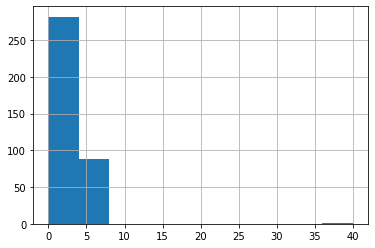

In [13]:
# Присутствует явный выброс. Вероятно, что вместо цифры 4 по ошибке ввели 40
students.Fedu.hist()

In [14]:
# Заменим 40 на 4 и заменим пропущенные значения на медиану
students['Fedu'] = students['Fedu'].replace(40.0, 4.0)
students.Fedu.fillna(students.Fedu.median(), inplace=True)

In [15]:
# Traveltime. 28 пустых значений.
students.traveltime.isnull().sum()

28

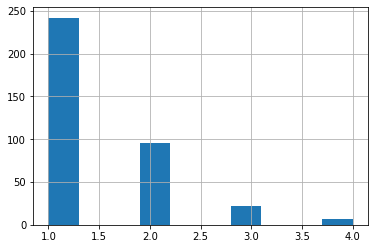

In [16]:
# Выбросов нет, все значения находятся в промежутке от 0 до 4 согласно заданным критериям
students.traveltime.hist()

In [17]:
# Возможно, время потраченное на поездку в школу зависит от того, живет ли ученик в городе или за городом.
# Я заполню пропуски медианными значениями в зависимости от того, где проживает ученик. Но для этого мне
# необходимо убедиться что в каждой строке с проском времени есть информация об адресе
students.loc[(students['address'].isnull())
             & (students['traveltime'].isnull())]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
241,GP,M,17,NaN,LE3,A,4.0,4.0,teacher,other,...,-6.0,1.0,1.0,0.0,3.0,3.0,NaN,4.0,2.0,60.0
348,GP,F,17,NaN,GT3,T,4.0,3.0,health,other,...,-9.0,1.0,1.0,1.0,NaN,4.0,3.0,4.0,0.0,75.0
372,MS,F,17,NaN,GT3,T,2.0,2.0,other,at_home,...,-9.0,1.0,0.0,NaN,3.0,4.0,3.0,3.0,8.0,55.0


In [18]:
# Но это не так, и для начала мне придется заполнить пропуски адресов. Отсуствуют 17 значений и очевидно, что большинсвто
# учеников - городские жители
students.address.isnull().sum()

17

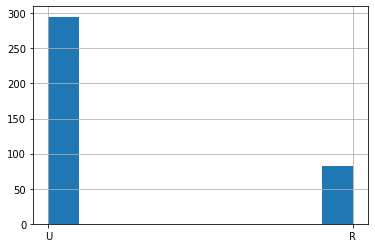

In [19]:
students.address.hist()

In [20]:
# Для времени поездки медианой является 1, поэтому предположу, что ученики, проживающие за городом,
# тратят на поездку больше времени
students.traveltime.median()

1.0

In [21]:
def fill_address(row):
    if pd.isnull(row['address']):
        if row['traveltime'] > 1:
            return 'R'
        else:
            return 'U'
    return row['address']


students['address'] = students.apply(fill_address, axis=1)

In [22]:
# Далее я заполню пропущенные значения столбца traveltime медианой, соответствуеющей адресу
def fill_time(row):
    if pd.isnull(row['traveltime']):
        if row['address'] == 'U':
            return students[students['address'] == 'U']['traveltime'].median()
        else:
            return students[students['address'] == 'R']['traveltime'].median()
    return row['traveltime']


students['traveltime'] = students.apply(fill_time, axis=1)

In [23]:
# Studytime.7 пустых значений.
students.studytime.isnull().sum()

7

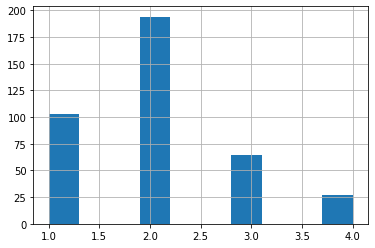

In [24]:
# Выбросов нет, все значения находятся в промежутке от 0 до 4 согласно заданным критериям
students.studytime.hist()

In [25]:
# Можно предположить, что время, уделяемое учебе зависит от того, сколько у студетов свободного времени, как часто они
# встречаются с друзьями и посещают внеучебняе занятия. Поэтому я проверю корреляцию с этимим параметрами
df = students[['studytime', 'freetime', 'goout', 'activities']].copy()
df.corr()

,studytime,freetime,goout,activities
studytime,1.000000,-0.121969,-0.051280,0.110905
freetime,-0.121969,1.000000,0.296437,0.074122
goout,-0.051280,0.296437,1.000000,0.045012
activities,0.110905,0.074122,0.045012,1.000000


In [26]:
# Отрицательная корреляция с freetime и goout действительно говорит о том, что чем больше у студента свободного времени,
# тем меньше у него времени на учебу. Но корреляция слабая, и, принимая во внимание, что пропущенных значений всего 7,
# я заполню их медианой
students.studytime.fillna(students.studytime.median(), inplace = True)

In [27]:
# Failures. 22 пустых значения.
students.failures.isnull().sum()

22

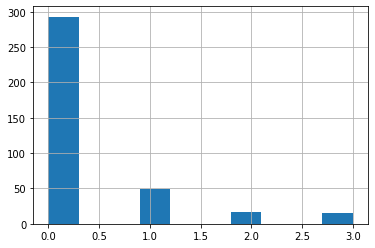

In [28]:
# Выбросов нет, все значения находятся в промежутке от 0 до 3 согласно заданным критериям
students.failures.hist()

In [29]:
# Возможно, количество внеучебных неудач зависит от наличия внеучебных занятий?
df = students[['failures', 'activities']].copy()
df.corr()

,failures,activities
failures,1.000000,-0.091205
activities,-0.091205,1.000000


In [30]:
# корреляция слабая, заполню медианой
students.failures.fillna(students.failures.median(), inplace=True)

In [31]:
# Studytime, granular. Информации об этом столбце нет и неясно, как его интерпертировать, поэтому я его удалю
students.drop('studytime, granular', axis=1, inplace=True)

In [32]:
# Famrel.27 пустых значений
students.famrel.isnull().sum()

27

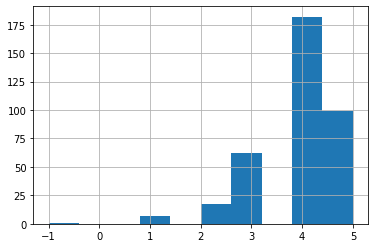

In [33]:
students.famrel.hist()

In [34]:
# одно значение меньше нуля. Скорее всего вместо 1 написали -1
students[students['famrel'] < 0]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,...,0.0,1.0,1.0,0.0,-1.0,2.0,2.0,5.0,14.0,40.0


In [35]:
# Заменим -1 на 1
students['famrel'] = students['famrel'].replace(-1, 1)

In [36]:
# Возможно, отношения в семье зависят от того, вместе ли родители? но разница в средних значениях незначительна
students[students.Pstatus == 'T'].famrel.mean() - students[students.Pstatus ==
                                                           'A'].famrel.mean()

0.049076460481099815

In [37]:
# Поэтому я заменю значения на медиану
students.famrel.fillna(students.famrel.median(), inplace=True)

In [38]:
# Freetime.11 пустых значений
students.freetime.isnull().sum()

11

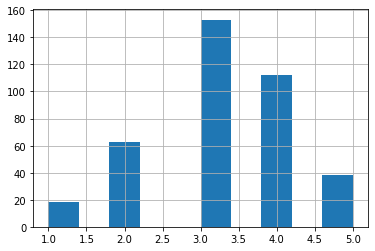

In [39]:
# Выбросов нет, все значения находятся в промежутке от 1 до 5 согласно заданным критериям
students.freetime.hist()

In [40]:
# Вероятно, те студенты, у которых больше свободного времени, проводят больше времени с друзьями
df = students[['freetime', 'goout']].copy()
df.corr()

,freetime,goout
freetime,1.000000,0.296437
goout,0.296437,1.000000


In [41]:
# Вероятно, те студенты, у которых больше свободного времени, проводят больше времени с друзьями, поэтому я подставлю
# немного разные значения в зависимости того, насколько часто студенты проводят время с друзьями
students[students.goout <= 3].freetime.median()

3.0

In [42]:
def fill_freetime(row):
    if pd.isnull(row['freetime']):
        if row['goout'] > 3:
            return students[students.goout > 3].freetime.median()
        else:
            return students[students.goout <= 3].freetime.median()
    return row['freetime']


students['freetime'] = students.apply(fill_freetime, axis=1)

In [43]:
# Freetime.8 пустых значений
students.goout.isnull().sum()

8

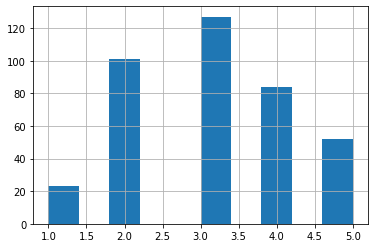

In [44]:
# Выбросов нет, все значения находятся в промежутке от 1 до 5 согласно заданным критериям
students.goout.hist()

In [45]:
# Так как я уже установила, что существует небольшая зависимость между кол-вом свободного времени и временем,
# проведенным с друзьями, применим здесь ту же логику
students.freetime.median()

3.0

In [46]:
# разница в среднем значении получается существенная
students[students.freetime > 3].goout.mean() - students[
    students.freetime <= 3].goout.mean()

0.610801687763713

In [47]:
def fill_goout(row):
    if pd.isnull(row['goout']):
        if row['freetime'] > 3:
            return students[students.freetime > 3].goout.median()
        else:
            return students[students.freetime <= 3].goout.median()
    return row['goout']


students['goout'] = students.apply(fill_goout, axis=1)

In [48]:
# Health.15 пустых значений
students.health.isnull().sum()

15

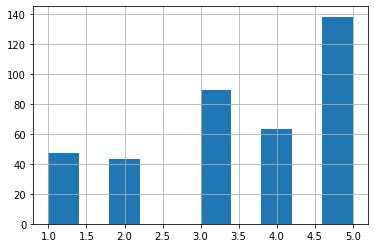

In [49]:
# Выбросов нет, все значения находятся в промежутке от 1 до 5 согласно заданным критериям
students.health.hist()

In [50]:
students.health.fillna(students.health.median(), inplace=True)

In [51]:
# Absences.12 пустых значений
students.absences.isnull().sum()

12

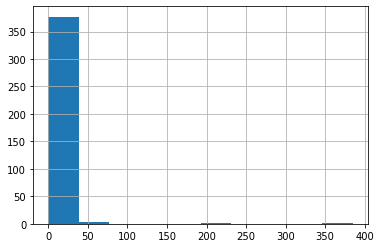

In [52]:
# Есть количество пропусков, которые сильно отличаются от большинства
students.absences.hist()

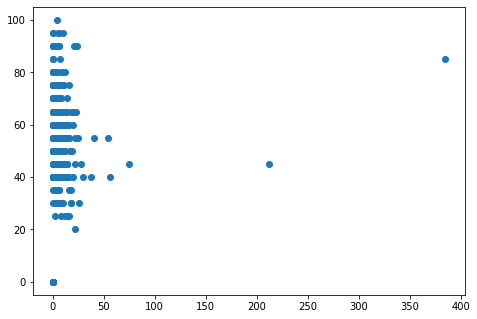

In [53]:
# Связи между большим кол-вом пропусков и оценкой не видно - студент, пропустивший больше всего, полчил достаточно высокий балл
# так что эти выбросы надо удалить
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
axes.scatter(x=students['absences'], y=students['score'], marker='o')

In [54]:
# Найдем границы выбросов
median = students.absences.median()
IQR = students.absences.quantile(0.75) - students.absences.quantile(0.25)
perc25 = students.absences.quantile(0.25)
perc75 = students.absences.quantile(0.75)
print('25-й перцентиль: {},'.format(perc25), '75-й перцентиль: {},'.format(perc75)
      , "IQR: {}, ".format(IQR),"Границы выбросов: [{f}, {l}].".format(f=perc25 - 1.5*IQR, l=perc75 + 1.5*IQR))

25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0,  Границы выбросов: [-12.0, 20.0].


In [55]:
students = students.loc[students.absences <= 20]


Далее обработаем столбцы со стороковыми данными

In [56]:
# Famsize.22 пустых значения
students.famsize.isnull().sum()

22

In [57]:
students.famsize.unique()

array([nan, 'GT3', 'LE3'], dtype=object)

In [58]:
# Заменю пропущенные значения наиболее часто встречающимися
students.famsize.fillna(students.famsize.mode()[0], inplace=True)

In [59]:
# Pstatus.38 пустых значений
students.Pstatus.isnull().sum()

38

In [60]:
students.Pstatus.value_counts()

T    296
A     32
Name: Pstatus, dtype: int64

In [61]:
# Можно предположить, что в тех случаях, когда опекуном не является ни отец, ни мать, родители не живут вместе
# Но видно , что это не так
students[students['guardian'] == 'other']

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
14,GP,M,15,U,GT3,A,2.0,2.0,other,other,...,1.0,1.0,1.0,1.0,4.0,5.0,2.0,3.0,0.0,80.0
127,GP,F,19,U,GT3,T,0.0,1.0,at_home,other,...,0.0,0.0,0.0,0.0,3.0,4.0,2.0,5.0,2.0,45.0
137,GP,F,16,U,GT3,A,3.0,2.0,other,other,...,0.0,1.0,1.0,1.0,4.0,3.0,2.0,5.0,0.0,0.0
152,GP,F,15,R,GT3,T,3.0,3.0,services,NaN,...,NaN,1.0,1.0,1.0,4.0,2.0,1.0,3.0,8.0,50.0
192,GP,M,17,U,GT3,T,1.0,2.0,at_home,services,...,0.0,1.0,1.0,0.0,4.0,4.0,4.0,5.0,12.0,40.0
210,GP,F,19,U,GT3,NaN,3.0,3.0,other,other,...,1.0,1.0,1.0,0.0,4.0,3.0,3.0,3.0,10.0,40.0
244,GP,F,18,U,GT3,T,2.0,1.0,other,other,...,0.0,1.0,1.0,1.0,4.0,4.0,4.0,3.0,0.0,NaN
251,GP,M,16,U,GT3,T,3.0,3.0,at_home,other,...,0.0,1.0,NaN,0.0,5.0,3.0,3.0,2.0,6.0,50.0
296,GP,F,19,U,GT3,T,4.0,4.0,health,other,...,1.0,1.0,1.0,0.0,2.0,3.0,4.0,2.0,0.0,0.0
297,GP,F,18,U,LE3,T,4.0,3.0,other,other,...,1.0,1.0,1.0,1.0,4.0,4.0,5.0,2.0,10.0,40.0


In [62]:
# Заменю пропущенные значения наиболее часто встречающимися
students.Pstatus.fillna(students.Pstatus.mode()[0], inplace = True)

In [63]:
# Mjob.16 пустых значений
students.Mjob.isnull().sum()

16

In [64]:
students.Mjob.value_counts()

other       123
services     88
at_home      55
teacher      52
health       32
Name: Mjob, dtype: int64

In [65]:
# Fjob.34 пустых значений
students.Fjob.isnull().sum()

34

In [66]:
students.Fjob.value_counts()

other       185
services     92
teacher      25
at_home      16
health       14
Name: Fjob, dtype: int64

In [67]:
# В целом данные в этих столбцах неиформативны, особенно учитывая, что наболее часто встречаюшееся значение - 'other'
# Поэтому я их удалю
students.drop('Mjob', axis=1, inplace=True)
students.drop('Fjob', axis=1, inplace=True)

In [68]:
# Reason.17 пустых значений
students.reason.isnull().sum()

17

In [69]:
students.reason.value_counts()

course        129
home           94
reputation     94
other          32
Name: reason, dtype: int64

In [70]:
# Возможно, что те студенты, которые выбрали школу из-за близости к дому, тратят на дорогу минимальное кол-во времени
# Это верно для больгиства студентов
len(students.loc[(students['traveltime'] == 1)
                 & (students['reason'] == 'home')])

70

In [71]:
# использую это при заполнении пустых значений, для остальных заполню наиболее частым значением
def fill_reason(row):
    if pd.isnull(row['reason']):
        if row['traveltime'] == 1:
            return 'home'
        else:
            return 'course'
    return row['reason']


students['reason'] = students.apply(fill_reason, axis=1)

In [72]:
# Guardian. 30 пустых значений
students.guardian.isnull().sum()

30

In [73]:
students.guardian.value_counts()

mother    229
father     83
other      24
Name: guardian, dtype: int64

In [74]:
# Заменю пропущенные значения наиболее часто встречающимися
students.guardian.fillna(students.guardian.mode()[0], inplace=True)

In [75]:
# Schoolsup
print(students.schoolsup.value_counts())
print(students.schoolsup.isnull().sum())

0.0    310
1.0     47
Name: schoolsup, dtype: int64
9


In [76]:
# Возможно наличие или отсутствие поддержки зависит от того, в какую школу ходят студенты
# Все студенты, получающие учебную поддержку, посещают GP
print(
    len(students[(students['schoolsup'] == 1) & (students['school'] == 'MS')]),
    len(students[(students['school'] == 'MS')
                 & (students['schoolsup'].isnull())]))

0 2


In [77]:
# Студентов, посещающих MS здесб всего двое. При этом большинство, посещающих другую школу, поддержки также не имеют
# Заменю пропущенные значения наиболее часто встречающимися
students.schoolsup.fillna(students.schoolsup.mode()[0], inplace=True)

In [78]:
# Famsup
print(students.famsup.value_counts())
print(students.famsup.isnull().sum())

1.0    204
0.0    127
Name: famsup, dtype: int64
35


In [79]:
# Возмжно наличие или отсутвие поддержки зависит от отношений в семье или же можно увидеть корреляцию между поддуржкой
# и временем, проведенным за учебой? Разница очень мала
df = students[['famsup', 'famrel', 'studytime']].copy()
df.corr()

,famsup,famrel,studytime
famsup,1.000000,-0.039560,0.115797
famrel,-0.039560,1.000000,0.028387
studytime,0.115797,0.028387,1.000000


In [80]:
# Заменю пропущенные значения наиболее часто встречающимися
students.famsup.fillna(students.famsup.mode()[0], inplace=True)

In [81]:
# Paid
print(students.paid.value_counts())
print(students.paid.isnull().sum())

0.0    189
1.0    139
Name: paid, dtype: int64
38


In [82]:
# Есть небольшая зависимость между наличием платных занятий, и временем, проведенным за учебой
df = students[['paid', 'studytime', 'activities']].copy()
df.corr()

,paid,studytime,activities
paid,1.000000,0.212846,0.007334
studytime,0.212846,1.000000,0.104735
activities,0.007334,0.104735,1.000000


In [83]:
# Предположим, что студенты, посещающие платные курсы,проводят больше среднего времени за учебой


def fill_paid(row):
    if pd.isnull(row['paid']):
        if row['studytime'] > students.studytime.median():
            return 'yes'
        else:
            return 'no'
    return row['paid']


students['paid'] = students.apply(fill_paid, axis=1)

In [84]:
# Activities
print(students.activities.value_counts())
print(students.activities.isnull().sum())

1.0    184
0.0    168
Name: activities, dtype: int64
14


In [85]:
# так как не удалось установить зависмость между 'activities' и другими показателями, то заполню значения наиболее частыми
students.activities.fillna(students.activities.mode()[0], inplace=True)

In [86]:
# Nursery
print(students.nursery.value_counts())
print(students.nursery.isnull().sum())

1.0    277
0.0     73
Name: nursery, dtype: int64
16


In [87]:
# Большинство студентов, не ходивших в садик, оказались из больших семей
len(students.loc[(students['nursery'] == 0) & (students['famsize'] == 'GT3')])

60

In [88]:
def fill_nursery(row):
    if pd.isnull(row['nursery']):
        if row['famsize'] == 'GT3':
            return 0
        else:
            return 1
    return row['nursery']


students['nursery'] = students.apply(fill_nursery, axis=1)

In [89]:
# Higher
print(students.higher.value_counts())
print(students.higher.isnull().sum())

1.0    332
0.0     16
Name: higher, dtype: int64
18


In [90]:
# Заменю пропущенные значения наиболее часто встречающимся
students.higher.fillna(students.higher.mode()[0], inplace=True)

In [91]:
# Internet
print(students.internet.value_counts())
print(students.internet.isnull().sum())

1.0    279
0.0     55
Name: internet, dtype: int64
32


In [93]:
# Возможно, у людей живущих за городом, ограниченный доступ к интернету?
# Они составляют менее половины людей, не имеющих доступа к интернету, так что, вероятно, это не определяющий признак
len(students[(students['internet'] == 0) & (students['address'] == 'R')])

23

In [94]:
# Заменю пропущенные значения наиболее часто встречающимся
students.internet.fillna(students.internet.mode()[0], inplace=True)

In [95]:
# Romantic
print(students.romantic.value_counts())
print(students.romantic.isnull().sum())

0.0    225
1.0    111
Name: romantic, dtype: int64
30


In [96]:
# Заменю пропущенные значения наиболее часто встречающимся
students.romantic.fillna(students.romantic.mode()[0], inplace=True)

In [97]:
# И в конце обработаем значения в столбце 'score'
students.score.isnull().sum()

5

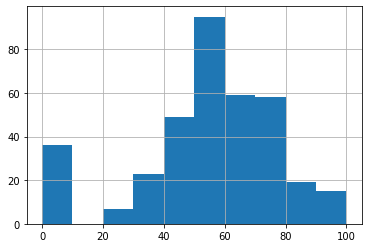

In [98]:
# Выбросов нет, все значения находятся в промежутке от 0 до 100 согласно заданным критериям
students.score.hist()

In [99]:
# Уберем строки с отсутствующими значениями, по ним нельзя определить влияние любых факторов на результат
students.dropna(axis=0, subset=['score'], inplace=True)

# корреляционный анализ количественных переменных

In [100]:
numeric_data = students[[
    'age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel',
    'freetime', 'goout', 'health', 'absences', 'score'
]]
numeric_data.corr()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,health,absences,score
age,1.000000,-0.164165,-0.161647,0.076113,0.000437,0.183789,0.052057,0.039860,0.128061,-0.061210,0.155469,-0.159306
Medu,-0.164165,1.000000,0.594371,-0.179177,0.086452,-0.237911,-0.011775,0.041658,0.053554,-0.061533,0.066077,0.206390
Fedu,-0.161647,0.594371,1.000000,-0.111918,0.003329,-0.272912,-0.018012,-0.017422,0.033312,0.003189,-0.027400,0.106860
traveltime,0.076113,-0.179177,-0.111918,1.000000,-0.095281,0.070292,-0.021608,-0.012863,0.037243,-0.009724,-0.040921,-0.080832
studytime,0.000437,0.086452,0.003329,-0.095281,1.000000,-0.166219,0.028779,-0.137636,-0.036733,-0.082885,-0.075256,0.112166
failures,0.183789,-0.237911,-0.272912,0.070292,-0.166219,1.000000,-0.008750,0.081866,0.071961,0.094170,0.081094,-0.322940
famrel,0.052057,-0.011775,-0.018012,-0.021608,0.028779,-0.008750,1.000000,0.168779,0.084198,0.082486,-0.087489,0.058827
freetime,0.039860,0.041658,-0.017422,-0.012863,-0.137636,0.081866,0.168779,1.000000,0.287849,0.042130,0.091072,0.032556
goout,0.128061,0.053554,0.033312,0.037243,-0.036733,0.071961,0.084198,0.287849,1.000000,0.001477,0.111216,-0.120448
health,-0.061210,-0.061533,0.003189,-0.009724,-0.082885,0.094170,0.082486,0.042130,0.001477,1.000000,-0.015157,-0.060110


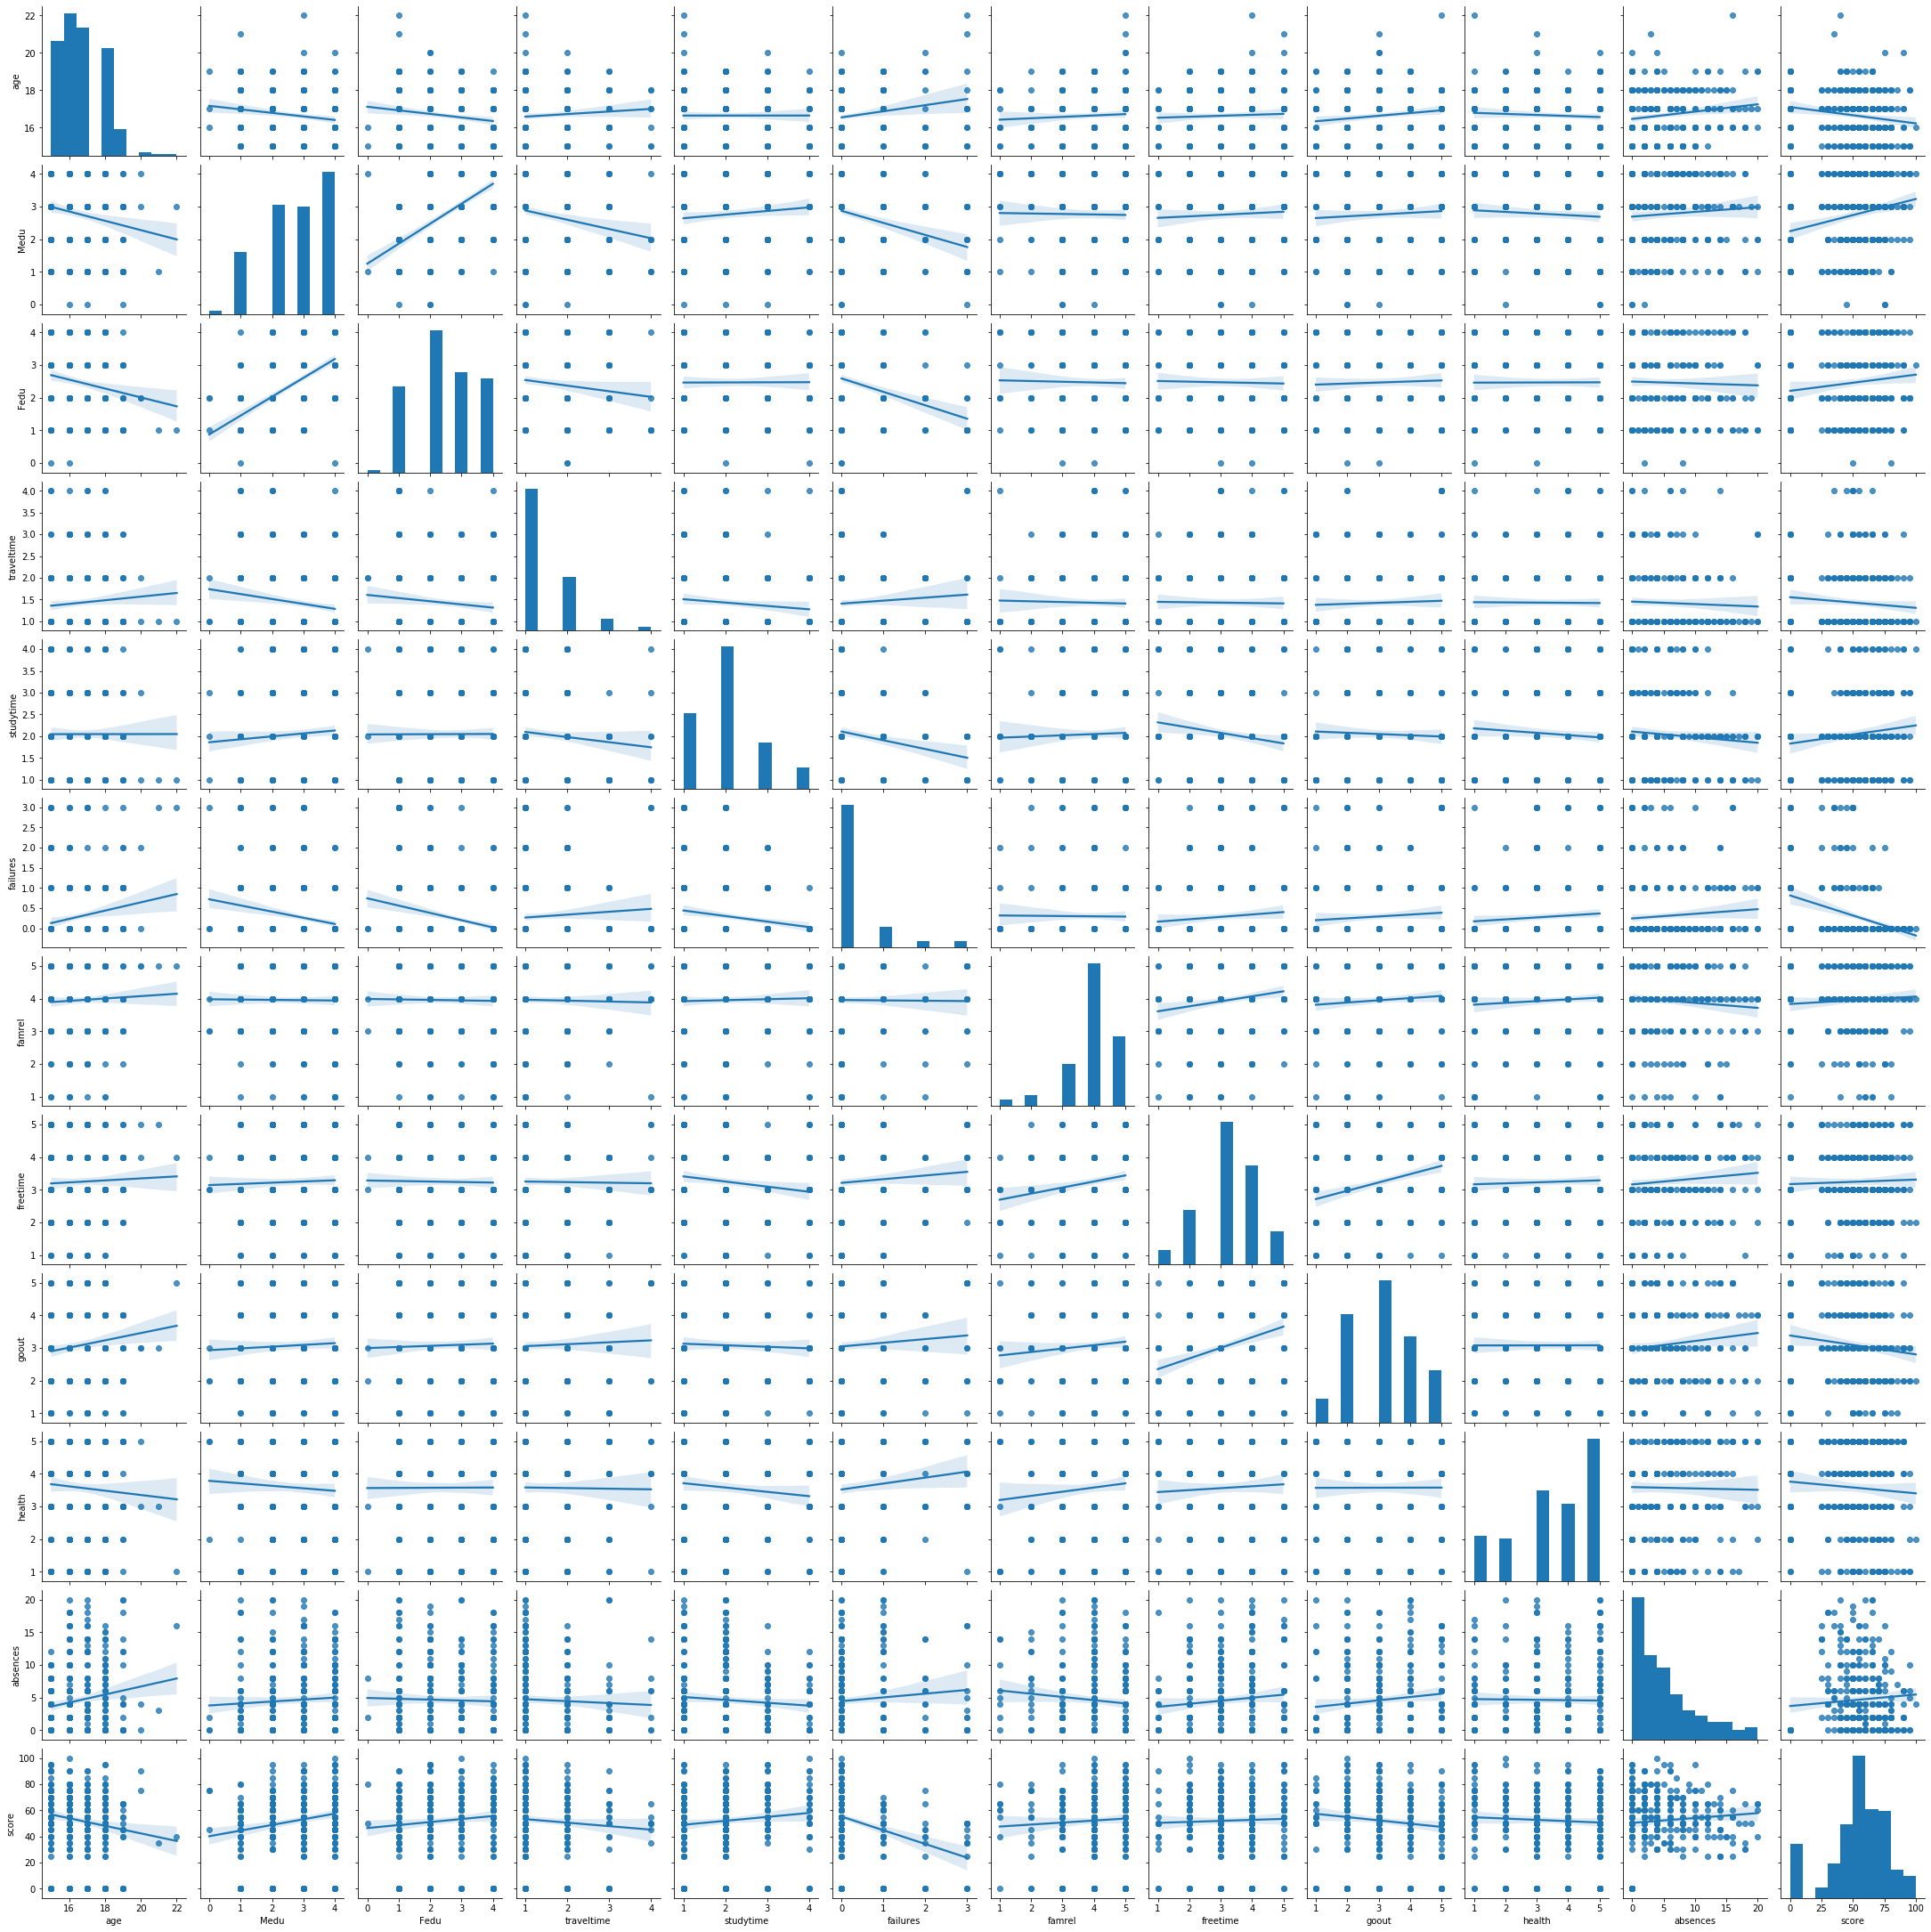

In [101]:
sns.pairplot(numeric_data, kind='reg')

Образование родителей достаточно сильно скореллировано, что вполне логично, потому как обычно пары составляют люди с близким социальным статусом. Я уберу колонку с образованием отца, так как оно оказывает меньшее влияние на итоговый балл, по сравнению с образованием матери

In [102]:
students.drop('Fedu', axis=1, inplace=True)

Среди прочего видно, что существует достачно сильная отрицательная корреляция между оценкой и неудачами, то есть чем выше балл, тем меньше неудач, и наоборот. Образование матери и возраст также оказывают влияние: более юные студенты справляются лучше, как и те, у кого матери получили лучшее образование. 


In [103]:
binary_data = students[[
    'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher',
    'internet', 'romantic', 'score'
]]
binary_data.corr()

,schoolsup,famsup,activities,nursery,higher,internet,romantic,score
schoolsup,1.000000,0.080756,0.093729,0.026830,0.040521,0.017194,-0.031189,-0.089532
famsup,0.080756,1.000000,-0.048305,0.086624,0.069588,0.102874,0.039069,-0.007795
activities,0.093729,-0.048305,1.000000,-0.038804,0.045580,0.082921,-0.008734,0.000991
nursery,0.026830,0.086624,-0.038804,1.000000,0.042266,0.066162,0.018463,0.080563
higher,0.040521,0.069588,0.045580,0.042266,1.000000,0.060631,-0.091371,0.162583
internet,0.017194,0.102874,0.082921,0.066162,0.060631,1.000000,0.058286,0.051734
romantic,-0.031189,0.039069,-0.008734,0.018463,-0.091371,0.058286,1.000000,-0.128477
score,-0.089532,-0.007795,0.000991,0.080563,0.162583,0.051734,-0.128477,1.000000


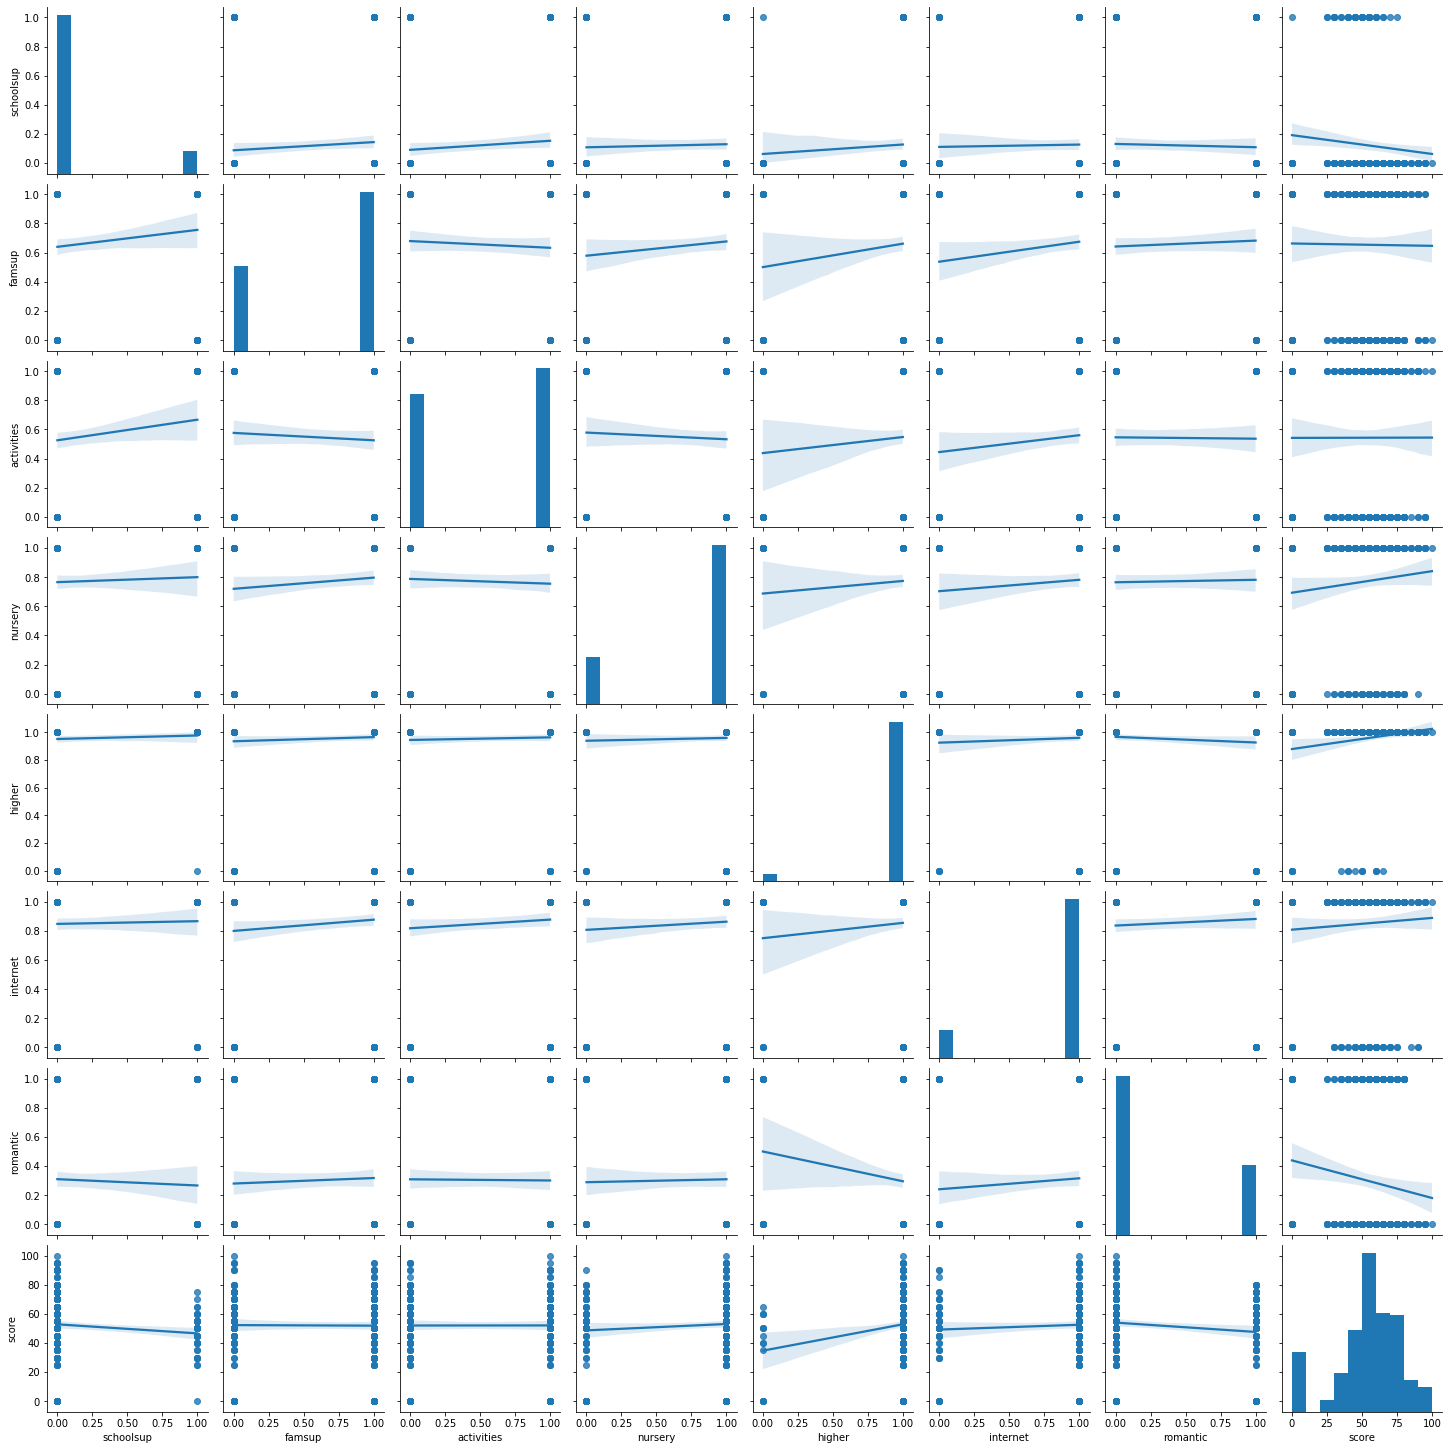

In [104]:
sns.pairplot(binary_data, kind='reg')

Желание получить высшее образование имеет наибольший коэффициент, однако, подавляющее большинство студентов ответило "да" на этот вопрос, при этом выскоие баллы получили немногие, поэтому использование этого признака для модели мне кажется нелогичныи.
Наличие платных курсов и отсутвие романтических отношений: несмотря на то, что показатель paid почти такой же как studytime, я выберу  paid, потому как это факт, в то время как кол-во времени, проведенного за учебой - субъективная оценка. Возможно, некоторым прилежным студентам не кажется, что, к примеру, 4 часа на учебу - это много времени, в то время как менее прилежным кажется, что это очень много. То же самое касается goout and romantic  - первое является субъективной оченкой, а второе - фактом. Вполне логично, что студенты, которые не состоят в романтических отношениях, меньше времени проводят с парой (goout), и возможно, они посвящают это время учебе.

# Анализ номинативных переменных

In [105]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(8, 4))
    sns.boxplot(x=column,
                y='score',
                data=students.loc[students.loc[:, column].isin(
                    students.loc[:, column].value_counts().index[:10])],
                ax=ax)
    plt.xticks(rotation=0)
    ax.set_title('Boxplot for ' + column)
    plt.show()

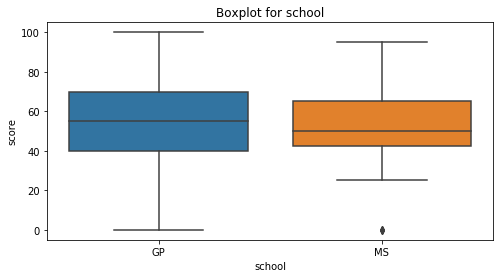

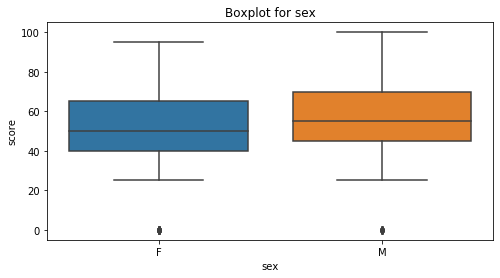

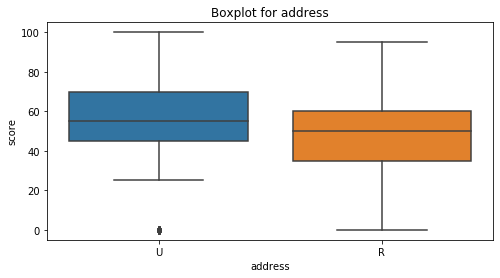

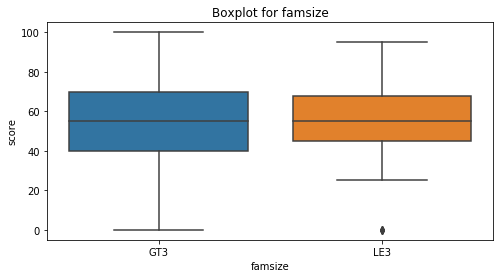

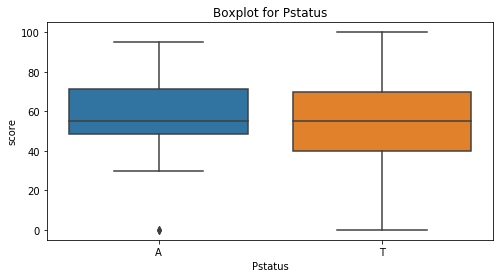

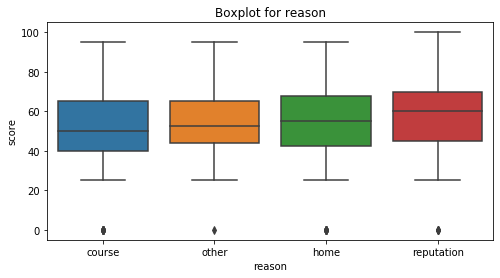

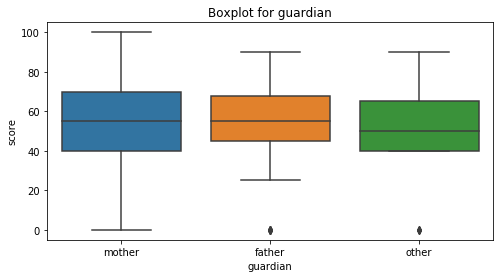

In [106]:
for col in [
        'school', 'sex', 'address', 'famsize', 'Pstatus', 'reason', 'guardian'
]:
    get_boxplot(col)

In [107]:
def get_stat_dif(column):
    cols = students.loc[:, column].value_counts().index[:10]
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(students.loc[students.loc[:, column] == comb[0], 'score'],
                        students.loc[students.loc[:, column] == comb[1], 'score']).pvalue \
            <= 0.05/len(combinations_all):
            print('Найдены статистически значимые различия для колонки',
                  column)
            break


for col in [
        'school', 'sex', 'address', 'famsize', 'Pstatus', 'reason', 'guardian'
]:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки sex
Найдены статистически значимые различия для колонки address


Кроме найденных пола и адреса, я включе также причину, так как на графике видно, что те студенты, которые выбирали школу по причине ее высокой репутации, получили наиболее высокие баллы, так как вероятно они более сфокусированы на получении образования, чем другие. Я также включу школу, так как для GP более высокие показатели максимальных и средних баллов, а студенты школы MS очень редко получают низкие баллы. Кроме того, мы уже знаем, что только студенты школы GP получали образовательную поддержку, так что возможно это тоже отразилось на результатах.

В итоге я использую следующие данные для построения модели:
failures, Medu, age, paid, romantic, school, sex, address, reason

In [108]:
students_for_model = students.loc[:, ['failures', 'Medu', 'age', 'paid', 'romantic', 'school', 'sex', 'address', 'reason']]
students_for_model.head()

,failures,Medu,age,paid,romantic,school,sex,address,reason
0,0.0,4.0,18,0,0.0,GP,F,U,course
1,0.0,1.0,17,0,0.0,GP,F,U,course
2,3.0,1.0,15,no,0.0,GP,F,U,other
3,0.0,4.0,15,1,1.0,GP,F,U,home
4,0.0,3.0,16,1,0.0,GP,F,U,home
